/Users/rishimane/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Class distribution (before balancing): Counter({1: 35218, 2: 22062, 0: 12427})
Before oversampling: Counter({1: 24652, 2: 15443, 0: 8699})
After oversampling: Counter({1: 24652, 0: 24652, 2: 24652})

🔹 FUSION MODEL 1 — ANN + Random Forest


/Users/rishimane/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


654/654 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
Best weights: p=0.40, q=0.60
Fusion Accuracy: 0.8641036675751924
[[3477    0  251]
 [   1 9929  636]
 [1009  945 4665]]
              precision    recall  f1-score   support

           0       0.77      0.93      0.85      3728
           1       0.91      0.94      0.93     10566
           2       0.84      0.70      0.77      6619

    accuracy                           0.86     20913
   macro avg       0.84      0.86      0.85     20913
weighted avg       0.87      0.86      0.86     20913



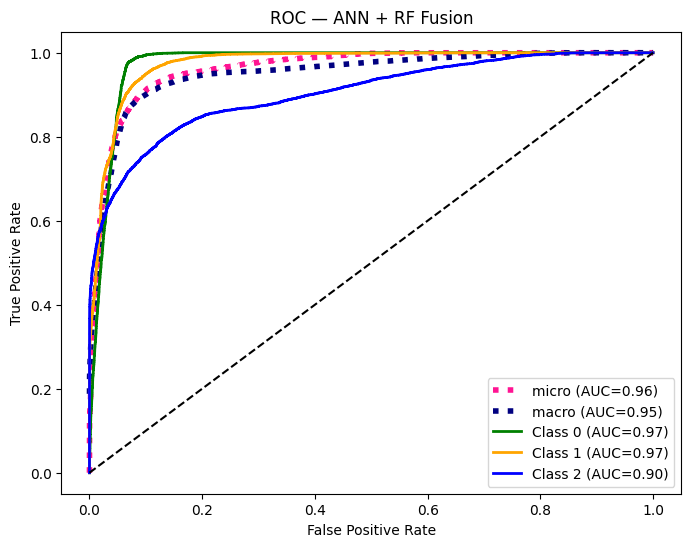


🔹 FUSION MODEL 2 — DT + AdaBoost


/Users/rishimane/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best weights: p=1.00, q=0.00
Fusion Accuracy: 0.868741930856405
[[ 3725     0     3]
 [    1 10157   408]
 [ 1242  1091  4286]]
              precision    recall  f1-score   support

           0       0.75      1.00      0.86      3728
           1       0.90      0.96      0.93     10566
           2       0.91      0.65      0.76      6619

    accuracy                           0.87     20913
   macro avg       0.86      0.87      0.85     20913
weighted avg       0.88      0.87      0.86     20913



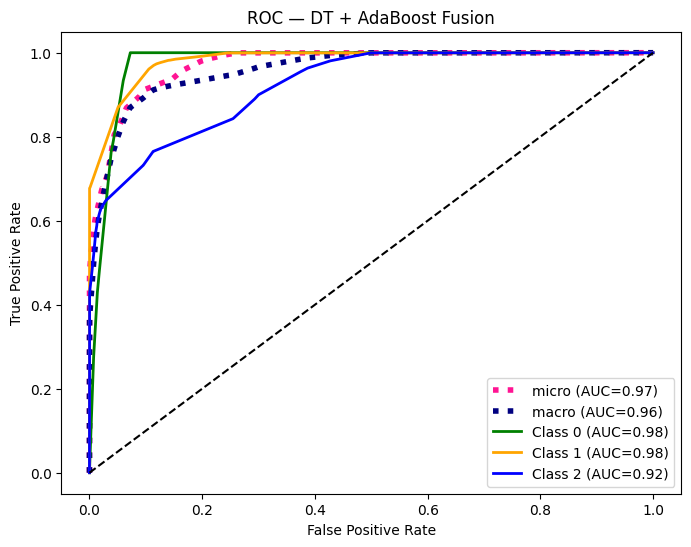


🔹 FUSION MODEL 3 — SVM + Logistic Regression


/Users/rishimane/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best weights: p=0.95, q=0.05
Fusion Accuracy: 0.6504088366088079
[[3511   77  140]
 [ 556 5965 4045]
 [1119 1374 4126]]
              precision    recall  f1-score   support

           0       0.68      0.94      0.79      3728
           1       0.80      0.56      0.66     10566
           2       0.50      0.62      0.55      6619

    accuracy                           0.65     20913
   macro avg       0.66      0.71      0.67     20913
weighted avg       0.68      0.65      0.65     20913



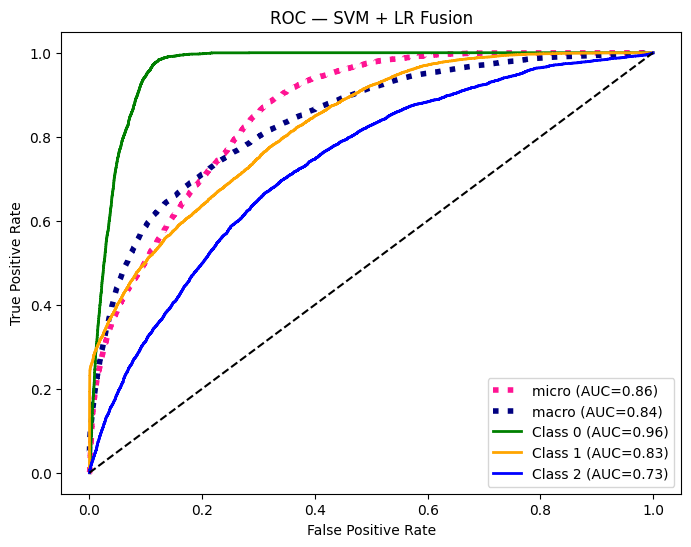

In [1]:
# =====================================================
# Cardiovascular Disease Severity Prediction (Multiclass)
# Fusion Models: ANN+RF, DT+AdaBoost, SVM+LR
# =====================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, label_binarize
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.utils import shuffle
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import matplotlib.pyplot as plt
from itertools import cycle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2

# -----------------------------------------------------
# STEP 1 — Load and preprocess Kaggle Cardio dataset
# -----------------------------------------------------
data = pd.read_csv("cardio_train.csv", sep=';')

# Basic cleaning
data = data.drop_duplicates()
data = data[(data['height'] > 140) & (data['height'] < 210)]  # remove extreme outliers
data = data[(data['weight'] > 40) & (data['weight'] < 180)]

# Feature engineering
data['age_years'] = (data['age'] / 365).astype(int)
data['BMI'] = data['weight'] / ((data['height']/100)**2)
data['bp_diff'] = data['ap_hi'] - data['ap_lo']

# -----------------------------------------------------
# STEP 2 — Convert binary target → multiclass severity
# -----------------------------------------------------
def assign_severity(row):
    if row['cardio'] == 0 and row['BMI'] < 25 and row['ap_hi'] < 130 and row['cholesterol'] == 1:
        return 0   # Low risk
    elif (row['cardio'] == 0 and row['BMI'] < 30) or (row['ap_hi'] >= 130 and row['ap_hi'] < 150) or (row['cholesterol'] == 2):
        return 1   # Medium risk
    else:
        return 2   # High risk

data['severity'] = data.apply(assign_severity, axis=1)
print("Class distribution (before balancing):", Counter(data['severity']))

# Drop unnecessary columns
data = data.drop(['id', 'cardio'], axis=1, errors='ignore')

# Define X, y
X = data.drop(['severity'], axis=1)
y = data['severity']

# -----------------------------------------------------
# STEP 3 — Train-Test split and balancing
# -----------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
print("Before oversampling:", Counter(y_train))

ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)
print("After oversampling:", Counter(y_train))

# -----------------------------------------------------
# Helper: ROC plot
# -----------------------------------------------------
def plot_multiclass_roc(y_true, y_score, title):
    n_classes = y_score.shape[1]
    y_bin = label_binarize(y_true, classes=list(range(n_classes)))
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    plt.figure(figsize=(8,6))
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4, label=f'micro (AUC={roc_auc["micro"]:.2f})')
    plt.plot(fpr["macro"], tpr["macro"], color='navy', linestyle=':', linewidth=4, label=f'macro (AUC={roc_auc["macro"]:.2f})')
    colors = cycle(['green','orange','blue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (AUC={roc_auc[i]:.2f})')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# -----------------------------------------------------
# STEP 4 — Fusion Model 1: ANN + Random Forest
# -----------------------------------------------------
print("\n🔹 FUSION MODEL 1 — ANN + Random Forest")

# Scaling
minmax = MinMaxScaler()
X_train_scaled = minmax.fit_transform(X_train)
X_test_scaled = minmax.transform(X_test)

# ANN
ann = Sequential([
    Dense(32, activation='relu', input_dim=X_train_scaled.shape[1], kernel_regularizer=l2(0.01)),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')
])
ann.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
ann.fit(X_train_scaled, y_train, epochs=20, batch_size=64, verbose=0)

ann_prob = ann.predict(X_test_scaled)
ann_pred = np.argmax(ann_prob, axis=1)

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
rf_prob = rf.predict_proba(X_test)

# Fusion
best_acc, best_p = 0, 0
for p in np.arange(1, 0, -0.05):
    q = 1 - p
    mix = ann_prob*p + rf_prob*q
    preds = np.argmax(mix, axis=1)
    acc = accuracy_score(y_test, preds)
    if acc > best_acc:
        best_acc, best_p = acc, p

p, q = best_p, 1 - best_p
fusion_prob = ann_prob*p + rf_prob*q
fusion_pred = np.argmax(fusion_prob, axis=1)

print(f"Best weights: p={p:.2f}, q={q:.2f}")
print("Fusion Accuracy:", accuracy_score(y_test, fusion_pred))
print(confusion_matrix(y_test, fusion_pred))
print(classification_report(y_test, fusion_pred))
plot_multiclass_roc(y_test, fusion_prob, "ROC — ANN + RF Fusion")

# -----------------------------------------------------
# STEP 5 — Fusion Model 2: Decision Tree + AdaBoost
# -----------------------------------------------------
print("\n🔹 FUSION MODEL 2 — DT + AdaBoost")

dt = DecisionTreeClassifier(max_depth=6, random_state=42)
ab = AdaBoostClassifier(n_estimators=100, random_state=42)
dt.fit(X_train, y_train)
ab.fit(X_train, y_train)

dt_prob = dt.predict_proba(X_test)
ab_prob = ab.predict_proba(X_test)

best_acc, best_p = 0, 0
for p in np.arange(1, 0, -0.05):
    q = 1 - p
    mix = dt_prob*p + ab_prob*q
    preds = np.argmax(mix, axis=1)
    acc = accuracy_score(y_test, preds)
    if acc > best_acc:
        best_acc, best_p = acc, p

p, q = best_p, 1 - best_p
fusion_prob = dt_prob*p + ab_prob*q
fusion_pred = np.argmax(fusion_prob, axis=1)

print(f"Best weights: p={p:.2f}, q={q:.2f}")
print("Fusion Accuracy:", accuracy_score(y_test, fusion_pred))
print(confusion_matrix(y_test, fusion_pred))
print(classification_report(y_test, fusion_pred))
plot_multiclass_roc(y_test, fusion_prob, "ROC — DT + AdaBoost Fusion")

# -----------------------------------------------------
# STEP 6 — Fusion Model 3: SVM + Logistic Regression
# -----------------------------------------------------
print("\n🔹 FUSION MODEL 3 — SVM + Logistic Regression")

std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)

svm = SVC(probability=True, kernel='rbf', C=1.0, random_state=42)
svm.fit(X_train_std, y_train)
svm_prob = svm.predict_proba(X_test_std)

lr = LogisticRegression(max_iter=500, multi_class='multinomial', C=0.5)
lr.fit(X_train_std, y_train)
lr_prob = lr.predict_proba(X_test_std)

best_acc, best_p = 0, 0
for p in np.arange(1, 0, -0.05):
    q = 1 - p
    mix = svm_prob*p + lr_prob*q
    preds = np.argmax(mix, axis=1)
    acc = accuracy_score(y_test, preds)
    if acc > best_acc:
        best_acc, best_p = acc, p

p, q = best_p, 1 - best_p
fusion_prob = svm_prob*p + lr_prob*q
fusion_pred = np.argmax(fusion_prob, axis=1)

print(f"Best weights: p={p:.2f}, q={q:.2f}")
print("Fusion Accuracy:", accuracy_score(y_test, fusion_pred))
print(confusion_matrix(y_test, fusion_pred))
print(classification_report(y_test, fusion_pred))
plot_multiclass_roc(y_test, fusion_prob, "ROC — SVM + LR Fusion")
